In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# Define a function to randomly add a grain to a position in the grid
@jit(nopython=True)
def add_grain(grid, L):
    x, y = np.random.randint(0, L, size=2)
    grid[x, y] += 1
    return x, y

# Handle the collapse, moving grains to the surrounding four lattice points
@jit(nopython=True)
def collapse(grid, L):
    total_avalanche_size = 0
    
    # Define four directions (dx, dy)
    directions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]])  # up, down, left, right

    # Initialize maximum extent length
    max_x_extent = 0
    max_y_extent = 0
    
    # Continue the collapse as long as there are lattice points with more than 1 grain
    while np.max(grid > 1):
        topple_sites = np.argwhere(grid > 1)  # Find all lattice points that need to collapse
        total_avalanche_size += len(topple_sites)  
        x_min, x_max = topple_sites[:, 0].min(), topple_sites[:, 0].max()
        y_min, y_max = topple_sites[:, 1].min(), topple_sites[:, 1].max()

        # Update the maximum extent length along the x and y axes
        max_x_extent = max(max_x_extent, 1 + x_max - x_min)
        max_y_extent = max(max_y_extent, 1 + y_max - y_min)

        for site in topple_sites:
            x, y = site
            grid[x, y] -= 2  # Reduce two grains at the current lattice point
            
            # Randomly distribute the two grains to four neighboring lattice points
            for _ in range(2):
                direction = np.random.randint(4)
                dx, dy = directions[direction]  # Get direction change values
                new_x, new_y = x + dx, y + dy

                # Check if the new position is within the boundary
                if 0 <= new_x < L and 0 <= new_y < L:
                    grid[new_x, new_y] += 1
                else:
                    # If outside the boundary, the grains overflow and are no longer part of the system
                    pass

    # Return the total number of collapsed grains and the largest extent
    return total_avalanche_size, max(max_x_extent, max_y_extent)

# Simulate the evolution of the system
@jit(nopython=True)
def simulate(grid, max_steps, L, n_0):
    # Use dynamic lists to store avalanche events
    avalanche_sizes = []
    max_extents = []
    
    for step in range(max_steps):
        # Randomly add a grain
        add_grain(grid, L)
        
        # Handle collapse until the system stabilizes
        total_avalanche_size, max_extent = collapse(grid, L)
        
        # Record avalanche events starting from step n_0
        if step >= n_0:
            #if total_avalanche_size > 0:  # Only record events where avalanche_size > 0
                avalanche_sizes.append(total_avalanche_size)
                max_extents.append(max_extent)  # Record the corresponding max_extent
    
    return np.array(avalanche_sizes), np.array(max_extents)


# Set L values
L_values = [400]  # Set different L values
max_steps = 200000
n_0 = 120000

# Record simulation results for all L values
all_avalanche_sizes = {}
all_max_extents = {}
# Run a simulation and save the data
for L in L_values:
    grid = np.zeros((L, L), dtype=int)
    avalanche_sizes, max_extents = simulate(grid, max_steps, L, n_0)
    all_avalanche_sizes[L] = avalanche_sizes
    all_max_extents[L] = max_extents


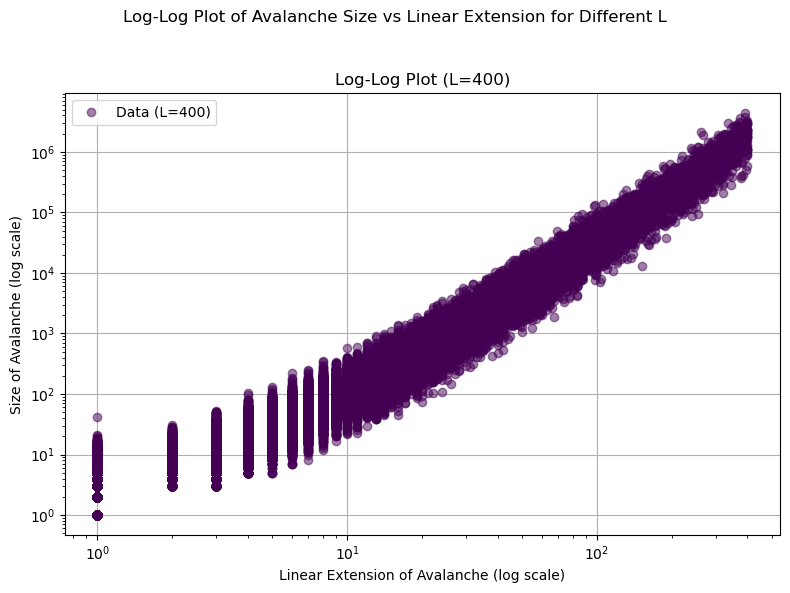

L=400: slope=2.01, R^2=0.95


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume all_avalanche_sizes and all_max_extents are recorded data for different L
# L_values can be adjusted freely here
L_values = list(all_avalanche_sizes.keys())  # Automatically generate the L list based on the dictionary
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values)))  # Dynamically generate a color list

# Check the number of L values and create subplots accordingly
if len(L_values) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    axs = [axs]  # Make axs a list to handle it uniformly later
else:
    fig, axs = plt.subplots(1, len(L_values), figsize=(18, 6))

# Store the fit results (slope and R^2) for different L values
fit_results = {}

# Loop through different L values and plot the log-log fit curve
for i, (L, color) in enumerate(zip(L_values, colors)):
    avalanche_sizes = all_avalanche_sizes[L]
    max_extents = all_max_extents[L]

    # Exclude zero values to avoid log(0) calculation issues
    non_zero_indices = (avalanche_sizes > 0) & (max_extents > 0)
    avalanche_sizes = avalanche_sizes[non_zero_indices]
    max_extents = max_extents[non_zero_indices]

    # Plot log-log graph
    axs[i].loglog(max_extents, avalanche_sizes, 'o', alpha=0.5, label=f'Data (L={L})', color=color)

    # Perform linear regression on log-log data to calculate slope and R^2
    log_lin_arr = np.log10(max_extents)
    log_ava_arr = np.log10(avalanche_sizes)
    slope, intercept, r_value, p_value, std_err = linregress(log_lin_arr, log_ava_arr)
    
    # Save slope and R^2
    fit_results[L] = {'slope': slope, 'R^2': r_value**2}

    # Plot the fitted line
    fit_line = 10**(intercept) * max_extents**slope
    #axs[i].loglog(max_extents, fit_line, 'r--', label=f'Fit: slope={slope:.2f}, $R^2$={r_value**2:.2f}')

    # Beautify the plot
    axs[i].set_xlabel('Linear Extension of Avalanche (log scale)')
    axs[i].set_ylabel('Size of Avalanche (log scale)')
    axs[i].set_title(f'Log-Log Plot (L={L})')
    axs[i].grid(True)
    axs[i].legend()

# Set the main title
fig.suptitle('Log-Log Plot of Avalanche Size vs Linear Extension for Different L')

# Adjust the layout of subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.show()

# Output the fit slope and R^2 for different L values
for L, result in fit_results.items():
    print(f"L={L}: slope={result['slope']:.2f}, R^2={result['R^2']:.2f}")


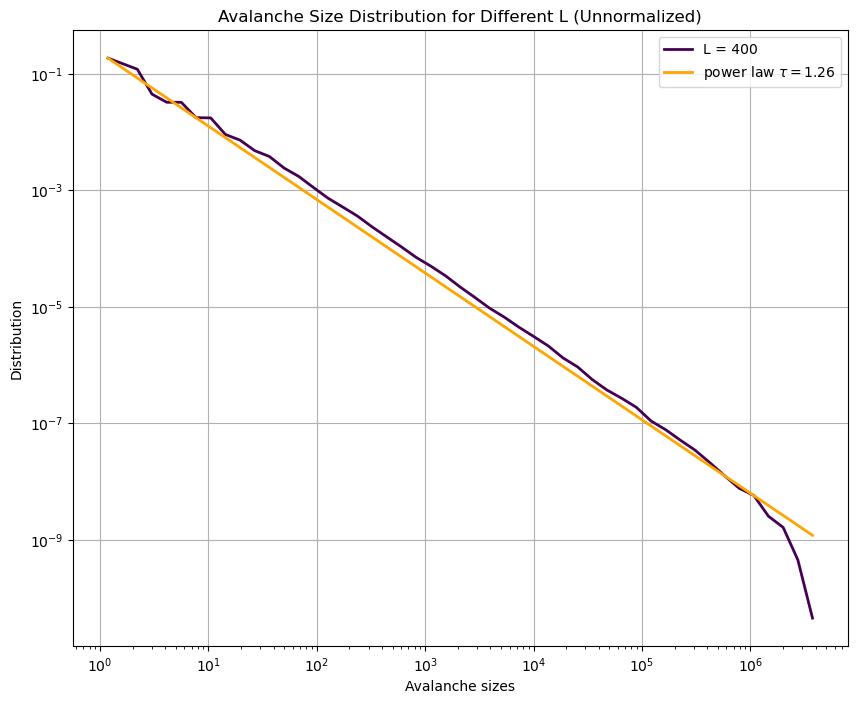

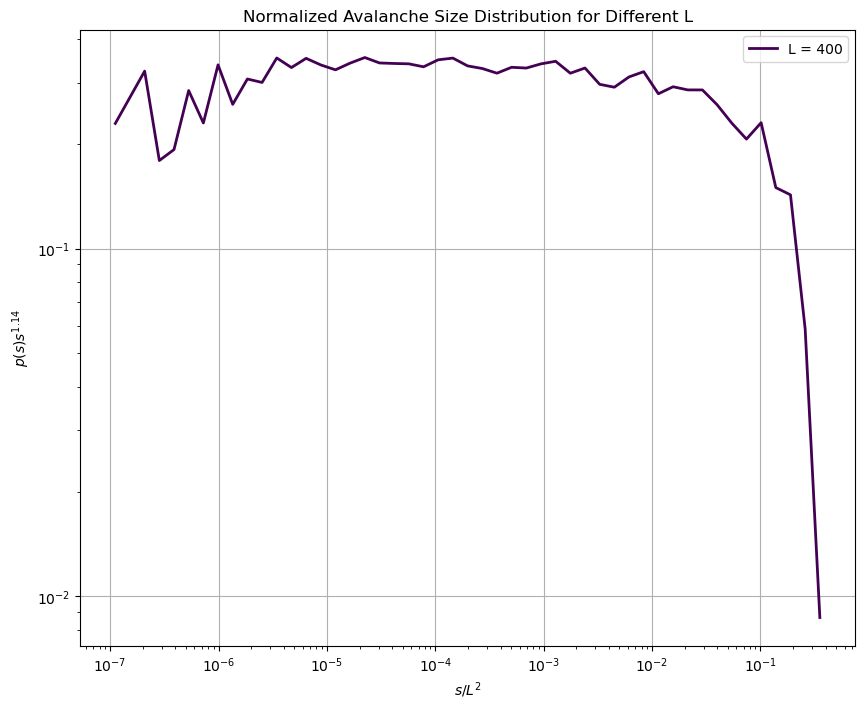

Steady state dynamics has not been reached yet for L = 400.


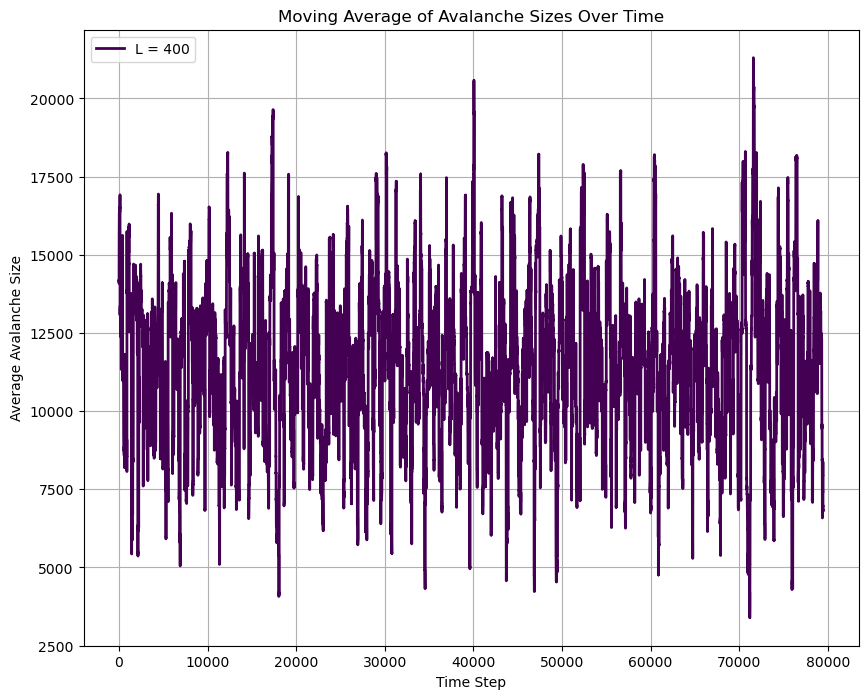

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Use matplotlib's colormap to generate a color list of the same length as L
colors = cm.viridis(np.linspace(0, 1, len(L_values)))  # 'viridis' is a colormap, you can change it to others

# -------------------------- Plot 1: Unnormalized Distribution -------------------------- #
plt.figure(figsize=(10, 8))

max_L = max(L_values)    # Maximum L value
power_law_plotted = False
max_L_hist = None
max_L_bin_centers = None

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Create a histogram of avalanche sizes, removing zero values to avoid vertical lines
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero values
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    # Plot the unnormalized distribution curve
    plt.loglog(bin_centers, hist, label=f'L = {L}', lw=2, color=color)
    
    # Save the data for the maximum L to align
    if L == max_L:
        max_L_hist = hist
        max_L_bin_centers = bin_centers
    
    # Plot the power law curve τ=1.3, aligned with the maximum L data only once
    if not power_law_plotted and max_L_hist is not None:
        tau = 1.26
        power_law = max_L_bin_centers ** (-tau)
        # Align the power law curve with the first point of the maximum L
        power_law *= max_L_hist[0] / power_law[0]  
        plt.loglog(max_L_bin_centers, power_law, label=fr'power law $\tau = {tau:.2f}$', lw=2, color='orange')
        power_law_plotted = True

# Beautify the plot
plt.xlabel('Avalanche sizes')
plt.ylabel('Distribution')
plt.title('Avalanche Size Distribution for Different L (Unnormalized)')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------- Plot 2: Normalized Distribution -------------------------- #
plt.figure(figsize=(10, 8))

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Create a histogram of avalanche sizes
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero values
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    # Calculate the distribution of p(s) * s^tau
    tau = 1.26
    adjusted_hist = hist * bin_centers ** tau
    
    # Normalize avalanche size s / L^2
    normalized_sizes = bin_centers / (L ** 2.7)
    
    # Plot the normalized distribution curve
    plt.loglog(normalized_sizes, adjusted_hist, label=f'L = {L}', lw=2, color=color)

# Beautify the plot
plt.xlabel(r'$s/L^2$')
plt.ylabel(r'$p(s) s^{1.14}$')
plt.title('Normalized Avalanche Size Distribution for Different L')
plt.grid(True)
plt.legend()
plt.show()

# -------------------------- Plot 3: System Stability -------------------------- #

# Compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Check if the system has reached steady state
def check_steady_state(avalanche_sizes, window_size=500, tolerance=28):
    moving_std = np.std(moving_average(avalanche_sizes, window_size))
    return moving_std < tolerance

window_size = 500

plt.figure(figsize=(10, 8))

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Compute the moving average
    avg_avalanche_sizes = moving_average(avalanche_sizes, window_size)
    
    # Check for steady state
    steady_state_reached = check_steady_state(avalanche_sizes)
    if steady_state_reached:
        print(f"Steady state dynamics has been reached for L = {L}.")
    else:
        print(f"Steady state dynamics has not been reached yet for L = {L}.")
    
    # Plot the moving average over time
    plt.plot(avg_avalanche_sizes, label=f'L = {L}', lw=2, color=color)

# Beautify the plot
plt.xlabel('Time Step')
plt.ylabel('Average Avalanche Size')
plt.title('Moving Average of Avalanche Sizes Over Time')
plt.grid(True)
plt.legend()
plt.show()


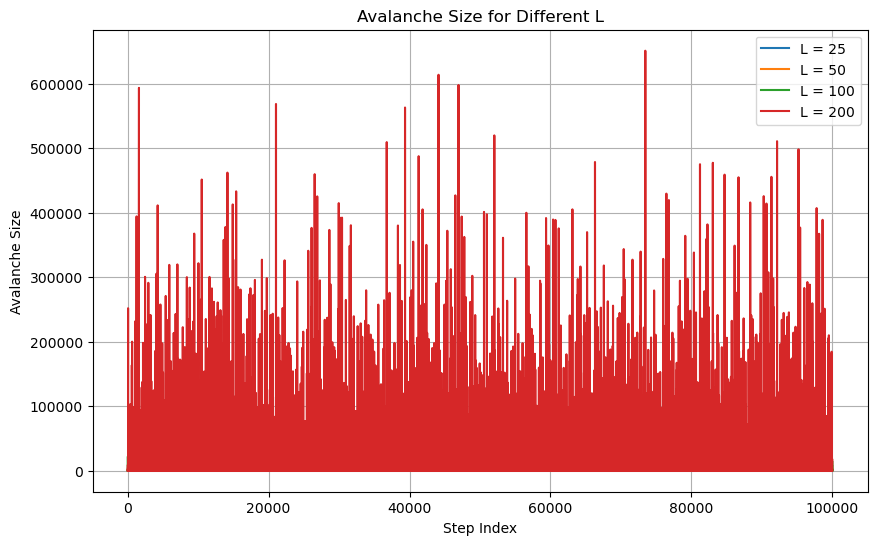

In [4]:
plt.figure(figsize=(10, 6))

# Loop through all L values and plot the corresponding avalanche sizes
for L in L_values:
    avalanche_sizes2 = all_avalanche_sizes[L]
    plt.plot(avalanche_sizes2, label=f"L = {L}")

# Add legend, labels, and title
plt.xlabel("Step Index")
plt.ylabel("Avalanche Size")
plt.title("Avalanche Size for Different L")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


KeyError: 400

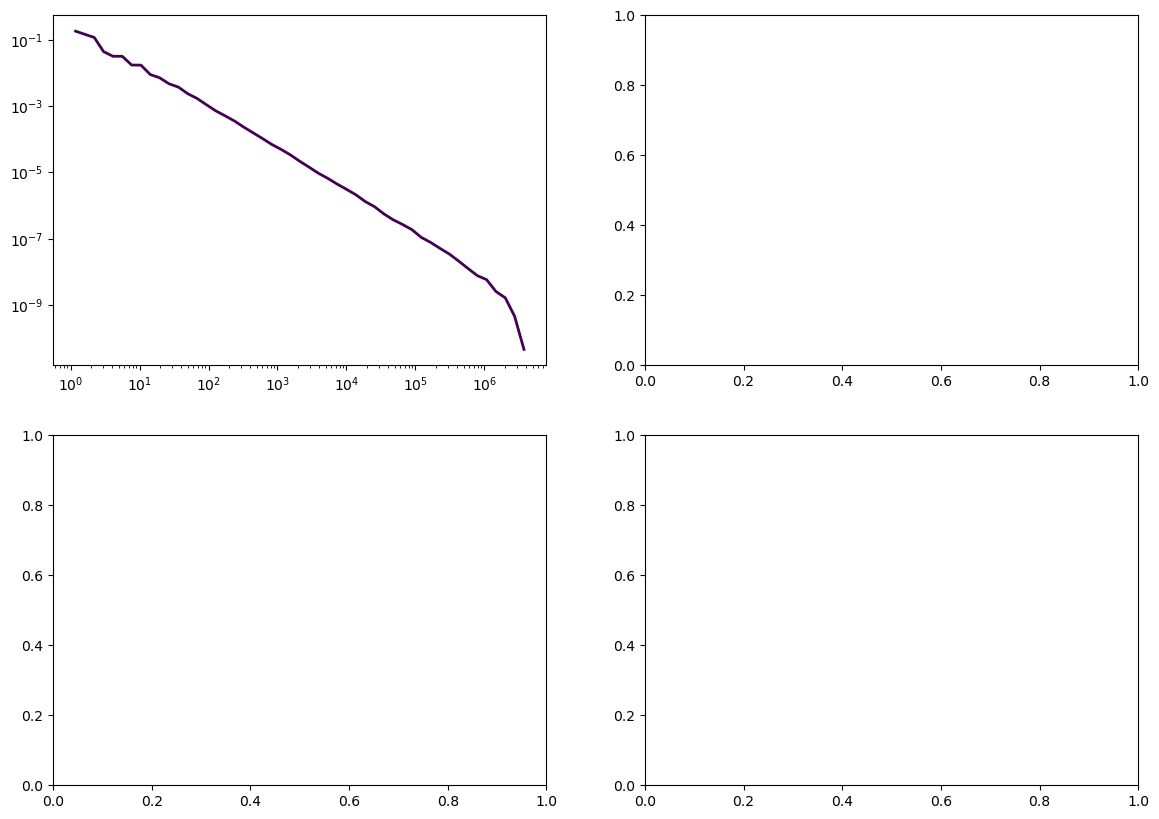

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Define different tau values for each L
tau_values = {
    25: 1.4, 
    50: 1.3, 
    100: 1.25, 
    200: 1.26
}

# Use matplotlib's colormap to generate a list of colors corresponding to the length of L_values
colors = cm.viridis(np.linspace(0, 1, len(L_values)))  # 'viridis' is a colormap, you can change it to others

# -------------------------- Plot 1: Unnormalized Distribution with 4 Subplots -------------------------- #
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, (L, color) in enumerate(zip(L_values, colors)):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Create a histogram of avalanche sizes, removing zero values to avoid vertical lines
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero values
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    ax = axs[i // 2, i % 2]  # Assign each plot to its own subplot
    
    # Plot the unnormalized distribution curve
    ax.loglog(bin_centers, hist, label=f'L = {L}', lw=2, color=color)
    
    # Get the specific tau for the current L
    tau = tau_values[L]
    
    # Plot the power-law curve τ with the current L data
    power_law = bin_centers ** (-tau)
    power_law *= hist[0] / power_law[0]  # Align the power law curve with the first point
    ax.loglog(bin_centers, power_law, label=fr'power law $\tau = {tau:.2f}$', lw=2, color='orange')
    
    # Beautify the plot
    ax.set_xlabel('Avalanche sizes')
    ax.set_ylabel('Distribution')
    ax.set_title(f'Unnormalized Distribution for L = {L}')
    ax.grid(True)
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# -------------------------- Plot 2: Normalized Distribution with 4 Subplots -------------------------- #
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, (L, color) in enumerate(zip(L_values, colors)):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Create a histogram of avalanche sizes
    hist, bin_edges = np.histogram(avalanche_sizes, bins=np.logspace(0, np.log10(max(avalanche_sizes)), 50), density=True)
    
    # Remove zero values
    non_zero_indices = hist > 0
    hist = hist[non_zero_indices]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_centers = bin_centers[non_zero_indices]
    
    ax = axs[i // 2, i % 2]  # Assign each plot to its own subplot
    
    # Get the specific tau for the current L
    tau = tau_values[L]
    
    # Calculate the distribution of p(s) * s^tau
    adjusted_hist = hist * bin_centers ** tau
    
    # Normalize avalanche sizes s / L^2
    normalized_sizes = bin_centers / (L ** 2)
    
    # Plot the normalized distribution curve
    ax.loglog(normalized_sizes, adjusted_hist, label=f'L = {L}', lw=2, color=color)
    
    # Beautify the plot
    ax.set_xlabel(r'$s/L^2$')
    ax.set_ylabel(fr'$p(s) s^{{{tau}}}$')
    ax.set_title(f'Normalized Distribution for L = {L}')
    ax.grid(True)
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# -------------------------- Plot 3: System Stability (unchanged) -------------------------- #

# Compute moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Check if the system has reached steady state
def check_steady_state(avalanche_sizes, window_size=500, tolerance=28):
    moving_std = np.std(moving_average(avalanche_sizes, window_size))
    return moving_std < tolerance

window_size = 500

plt.figure(figsize=(10, 8))

for L, color in zip(L_values, colors):
    avalanche_sizes = all_avalanche_sizes[L]
    
    # Compute the moving average
    avg_avalanche_sizes = moving_average(avalanche_sizes, window_size)
    
    # Check for steady state
    steady_state_reached = check_steady_state(avalanche_sizes)
    if steady_state_reached:
        print(f"Steady state dynamics has been reached for L = {L}.")
    else:
        print(f"Steady state dynamics has not been reached yet for L = {L}.")
    
    # Plot the moving average over time
    plt.plot(avg_avalanche_sizes, label=f'L = {L}', lw=2, color=color)

# Beautify the plot
plt.xlabel('Time Step')
plt.ylabel('Average Avalanche Size')
plt.title('Moving Average of Avalanche Sizes Over Time')
plt.grid(True)
plt.legend()
plt.show()


In [8]:
# 计算不同L值下的崩塌频率
from collections import Counter

# Function to compute frequency of avalanche sizes for each system size L
def compute_avalanche_frequencies(avalanche_sizes_dict):
    result_list = []
    for L, avalanche_sizes in avalanche_sizes_dict.items():
        # Filter out avalanche sizes of 0
        filtered_sizes = avalanche_sizes[avalanche_sizes > 0]
        size_counts = Counter(filtered_sizes)
        total_avalanches = sum(size_counts.values())
        # Create a list of [size, frequency] and filter out frequency=0
        size_freq_list = [[size, count / total_avalanches] for size, count in size_counts.items() if count > 0]
        result_list.append(size_freq_list)
    return result_list

# 用模拟生成的all_avalanche_sizes计算频率
frequencies_per_L = compute_avalanche_frequencies(all_avalanche_sizes)


# 进行log-log回归
import numpy as np
from scipy import stats
from collections import Counter

# Function to fit log-log regression with log base 10 and specific size range filtering for different L values
def fit_log_log_regression_base10(avalanche_sizes_dict, L_values):
    slopes_r2_list = []
    
    # Define the size ranges for different L values
    size_ranges = {25: (0, 700), 50: (0, 700), 100: (0, 700), 200: (0, 700)}
    
    for L in L_values:
        avalanche_sizes = avalanche_sizes_dict[L]
        min_size, max_size = size_ranges.get(L, (1, np.inf))  # Default range if L is not in size_ranges
        
        # Filter out avalanche sizes of 0 and outside the specified range
        filtered_sizes = avalanche_sizes[(avalanche_sizes > 0) & (avalanche_sizes >= min_size) & (avalanche_sizes <= max_size)]
        
        # Count frequencies of filtered sizes
        size_counts = Counter(filtered_sizes)
        total_avalanches = sum(size_counts.values())
        
        if total_avalanches == 0:
            slopes_r2_list.append((np.nan, np.nan))  # Skip if no avalanches in the range
            continue
        
        # Create list of [size, frequency]
        size_freq_list = np.array([[size, count / total_avalanches] for size, count in size_counts.items()])
        
        # Take log10 of both size and frequency
        log_sizes = np.log10(size_freq_list[:, 0])
        log_freqs = np.log10(size_freq_list[:, 1])
        
        # Perform linear regression on log-log data
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_sizes, log_freqs)
        
        # Store slope and R^2 value (r_value**2 gives R²)
        slopes_r2_list.append((slope, r_value**2))
    
    return slopes_r2_list

# Example usage:
slopes_and_r2 = fit_log_log_regression_base10(all_avalanche_sizes, L_values)
print(slopes_and_r2)


[(-1.4035863050298678, 0.9391176098701711), (-1.272308549571455, 0.9466868498489646), (-1.241765868815194, 0.9445759460034008), (-1.2260309987470681, 0.9398941790516322)]


In [9]:
import numpy as np
from scipy import stats
from collections import Counter

# Function to fit log-log regression with log base 10, specific size range filtering for different L values, and aggregate all data for regression
def fit_log_log_regression_aggregate(avalanche_sizes_dict, L_values):
    all_filtered_sizes = []
    
    # Define the size ranges for different L values
    size_ranges = {25: (0, 700), 50: (0, 700), 100: (0, 700), 200: (0, 700)}
    
    # Filter and aggregate data from all system sizes
    for L in L_values:
        avalanche_sizes = avalanche_sizes_dict[L]
        min_size, max_size = size_ranges.get(L, (1, np.inf))  # Default range if L is not in size_ranges
        
        # Filter out avalanche sizes of 0 and outside the specified range
        filtered_sizes = avalanche_sizes[(avalanche_sizes > 0) & (avalanche_sizes >= min_size) & (avalanche_sizes <= max_size)]
        all_filtered_sizes.extend(filtered_sizes)
    
    # Count frequencies of all filtered sizes
    size_counts = Counter(all_filtered_sizes)
    total_avalanches = sum(size_counts.values())
    
    if total_avalanches == 0:
        return np.nan, np.nan  # If no avalanches in the range, return NaN
    
    # Create list of [size, frequency]
    size_freq_list = np.array([[size, count / total_avalanches] for size, count in size_counts.items()])
    
    # Take log10 of both size and frequency
    log_sizes = np.log10(size_freq_list[:, 0])
    log_freqs = np.log10(size_freq_list[:, 1])
    
    # Perform linear regression on log-log data
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_sizes, log_freqs)
    
    # Return slope and R^2 value (r_value**2 gives R²)
    return slope, r_value**2

# Example usage:
L_values = [25, 50, 100, 200]
slope, r_squared = fit_log_log_regression_aggregate(all_avalanche_sizes, L_values)
print("Slope:", slope)
print("R^2:", r_squared)


Slope: -1.26303763821257
R^2: 0.9847206654754688


In [32]:
import numpy as np
from scipy import stats

# Function to perform power-law regression: avalanche_sizes ~ lin_extents^D
def fit_power_law_regression(avalanche_sizes_dict, lin_extents_dict, lin_extents_threshold=30):
    all_filtered_avalanche_sizes = []
    all_filtered_lin_extents = []

    # Filter data based on lin_extents threshold and aggregate data
    for L in avalanche_sizes_dict:
        avalanche_sizes = avalanche_sizes_dict[L]
        lin_extents = lin_extents_dict[L]

        # Filter only lin_extents greater than the specified threshold
        mask = (lin_extents > lin_extents_threshold)
        filtered_avalanche_sizes = avalanche_sizes[mask]
        filtered_lin_extents = lin_extents[mask]
        
        all_filtered_avalanche_sizes.extend(filtered_avalanche_sizes)
        all_filtered_lin_extents.extend(filtered_lin_extents)

    # Convert to numpy arrays
    all_filtered_avalanche_sizes = np.array(all_filtered_avalanche_sizes)
    all_filtered_lin_extents = np.array(all_filtered_lin_extents)
    
    # Log-transform both variables
    log_ava_sizes = np.log10(all_filtered_avalanche_sizes)
    log_lin_extents = np.log10(all_filtered_lin_extents)

    # Perform linear regression on log-log data
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_lin_extents, log_ava_sizes)

    # Return slope (D) and R^2 value
    return slope, r_value**2

# Example usage:
slope, r_squared = fit_power_law_regression(all_avalanche_sizes, all_max_extents)
print(f"slope (D): {slope}")
print(f"R^2: {r_squared}")


斜率 (D): 2.703244825743268
R^2: 0.9264151095122753
